<a href="https://colab.research.google.com/github/LiucijaSvink/mental_health_survey_analysis/blob/main/EDA_Mental_Health_in_Tech_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health in the technology industry analysis

## Introduction

Mental health determines our capacity to handle stress, create relationships and make healthy decisions. Although the importance of mental health is acknowledged, a stigma surrounding mental illness topic also exists. In this notebook, we are going to explore Open Source Mental Illness survey data from [Kaggle](https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry). The dataset description idenitifies that the survey measures the frequency of mental health disorders and the attitude towards the mental health of people working in tech.

In this notebook, we aim to investigate the overall mental health status of the repondents of the survey and the interference of mental issues with their work. Furthermore, we will explore the attitudes of employers and employees towards mental health.  

## Preparation

We will start with importing libraries necessary for the analysis. Note that the notebook requires **geopandas** installation to run smoothly.

In [35]:
import numpy as np
import pandas as pd
import sqlite3 as sql

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas

Helper functions are also defined below.

In [36]:
def annotate_bars(bars):
  '''Annotate horizontal graphs'''
  for bar in bars.patches:
    bars.annotate("%.0f" % bar.get_width(),
                  xy=(bar.get_width(),
                  bar.get_y() + bar.get_height()/2),
                  xytext=(5, 0),
                  textcoords='offset points',
                  ha="left",
                  va="center")
  return

def show_nonzero(values):
  return ('%.1f%%' % values) if values > 0.5 else ''

## Loading data

The data at hand is a SLQLite database that contains 3 tables. Survey, Question, and Answer.

* **Survey** (PRIMARY KEY INT SurveyID, TEXT Description)
* **Question** (PRIMARY KEY QuestionID, TEXT QuestionText)
* **Answer** (PRIMARY/FOREIGN KEY SurveyID, PRIMARY KEY UserID, PRIMARY/FOREIGN KEY QuestionID, TEXT AnswerText)

We will load and inspect the data.

In [37]:
connection = sql.connect("mental_health.sqlite")
survey_info = pd.read_sql("""
                          SELECT * 
                          FROM Survey
                          """, connection)

survey_info.head()

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


First table describes the years in which the survey was conducted.

In [38]:
questions = pd.read_sql("""
                        SELECT * 
                        FROM Question
                        """, connection)

questions.set_index("questionid").head(10)

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state ..."
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental he...
8,How many employees does your company or organi...
9,Is your employer primarily a tech company/orga...


Second table shows questions that were asked in the mental health survey and their ID. 

In [39]:
answers = pd.read_sql("""
                      SELECT * 
                      FROM Answer
                      """, connection)

answers.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


Last table contains the answers to the questions as well as some additional columns allowing to identify the year of the survey and associate the answer to the question.

## Data inspection

First, we will inspect the number of survey questions throughout the years.

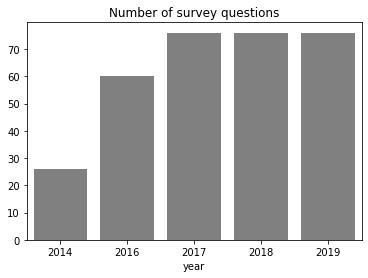

In [40]:
year_questions = pd.read_sql("""
                             SELECT SurveyID AS year, 
                                    COUNT(DISTINCT QuestionID) AS no_questions
                             FROM Answer 
                             GROUP BY year
                             ORDER BY year
                             """, connection)

sns.barplot(x="year", y="no_questions", data=year_questions, color="grey");

plt.title("Number of survey questions");
plt.ylabel(None);

We can observe that the survey was not conducted in the year 2015. We see that the number of questions varied across different years.

Similarly, the number of respondents per year will be checked.

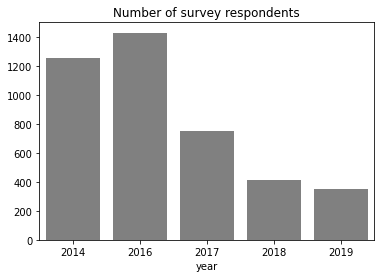

In [41]:
year_respondents = pd.read_sql("""
                               SELECT SurveyID AS year, 
                                      COUNT(DISTINCT UserID) AS no_respondents
                               FROM Answer 
                               GROUP BY year
                               ORDER BY year
                               """, connection)

sns.barplot(x="year", y="no_respondents", data=year_respondents, color="grey");

plt.title("Number of survey respondents");
plt.ylabel(None);

We see that most of the responses were received in 2016 and 2014 and reduced in years 2017, 2018, 2019.

## Respondents

In this section, we will have a look at the demographic profile of the respondents. We will start with the age.

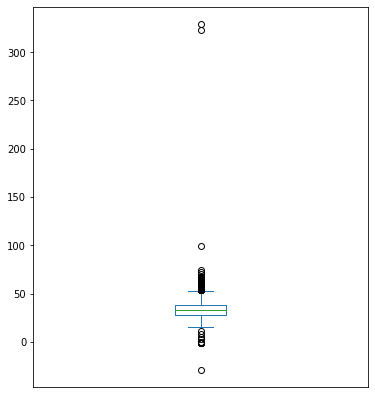

In [42]:
respondent_age = pd.read_sql("""
                            SELECT UserID, CAST(AnswerText AS int) AS age
                            FROM Answer
                            WHERE QuestionID = 1
                            """, connection)

axis = respondent_age.age.plot.box(figsize=(6, 7));

axis.get_xaxis().set_visible(False);

The age variable has some unexpected values - some of them are negative or range above 100. Since the survey and its questions target individuals working in tech industry, we will only include the respondents with a reasonable working age range: from 16 to 70 years. Then, they will be grouped into age groups with an increment of 5.

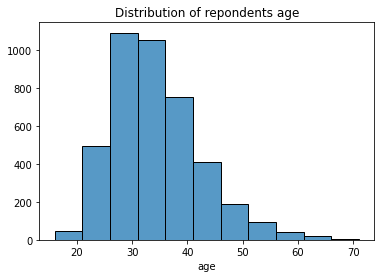

In [43]:
respondent_age = pd.read_sql("""
                             SELECT UserID, CAST(AnswerText AS int) AS age
                             FROM Answer
                             WHERE QuestionID = 1 
                             AND age >= 15 
                             AND age <= 70
                             """, connection)

sns.histplot(respondent_age, x="age", bins=np.arange(16, 72, 5));

plt.title("Distribution of repondents age")
plt.ylabel(None);

We see that the age distribution is right-tailed with most of the respondents falling in the 26-30 year category.   

Next, we will inspect the gender of the respondents.

In [44]:
gender_answer = pd.read_sql("""
                            SELECT AnswerText AS answer, 
                                   COUNT(DISTINCT UserID) AS no_respondents
                            FROM (SELECT AnswerText, UserID
                                 FROM Answer
                                 WHERE QuestionID = 2) 
                            GROUP BY AnswerText
                            ORDER BY no_respondents DESC
                            """, connection)

gender_answer.head(12)

,answer,no_respondents
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
5,Nonbinary,8
6,non-binary,6
7,Genderqueer,4
8,Agender,4
9,None,3


There is a big variety of the answers to the question "What is your gender?". First, we can notice that some of the answers contain '-1' which most likely identifies that the answer was not provided or is unknown. Hence, these answers will be excluded here and throughout the rest of the notebook.

The remaining answers will be categorized into 3 groups: *female*, *male* and *other*. *Other* category will contain all respondents who did not include the common female or male identification keywords.

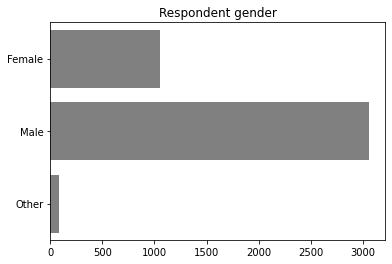

In [45]:
respondent_gender = pd.read_sql("""
                                SELECT COUNT(UserID) as no_respondents,
                                       CASE
                                          WHEN LOWER(AnswerText) LIKE "%fem%"
                                          OR LOWER(AnswerText) LIKE "%girl%"
                                          OR LOWER(AnswerText) LIKE "%woman%" 
                                          THEN "female"
                                          WHEN LOWER(AnswerText) LIKE "%man%"
                                          OR LOWER(AnswerText) LIKE "%male%"
                                          OR LOWER(AnswerText) LIKE "%guy%"
                                          OR LOWER(AnswerText) LIKE "%boy%"
                                          OR LOWER(AnswerText) LIKE "%mascul%" 
                                          THEN "male"
                                          ELSE "other"
                                       END AS gender
                               FROM (SELECT AnswerText, UserID
                                     FROM Answer
                                     WHERE QuestionID = 2 
                                     AND AnswerText IS NOT "-1") 
                               GROUP BY gender
                               """, connection)

axis = sns.barplot(x="no_respondents",
            y="gender",
            data=respondent_gender, color="grey");

axis.set(yticklabels=["Female", "Male", "Other"])
plt.title("Respondent gender")
plt.xlabel(None);
plt.ylabel(None);

Majority of the respondents were men. 

Next, we will look at from which countries the respondents came from.

In [46]:
respondent_country = pd.read_sql("""
                                 SELECT AnswerText AS country_name, 
                                        COUNT(DISTINCT UserID) AS no_respondents
                                        FROM (SELECT AnswerText, UserID
                                              FROM Answer
                                              WHERE QuestionID = 3 
                                              AND AnswerText IS NOT '-1') 
                                 GROUP BY AnswerText
                                 ORDER BY no_respondents DESC
                                 """, connection)

respondent_country.head()

,country_name,no_respondents
0,United States of America,1853
1,United States,751
2,United Kingdom,482
3,Canada,199
4,Germany,136


The dataframe above shows that a lot of respondents live in the United States of America (USA). The USA also seems to appear with two names in the list. We will write a modified query that will unify these names. Afterwards, we will print out all other country names sorted alphabetically to check for similar duplicates

In [47]:
respondent_country = pd.read_sql("""
                                  SELECT
                                        CASE
                                            WHEN AnswerText = "United States" 
                                            THEN "United States of America"
                                            ELSE AnswerText
                                        END AS country_name, 
                                        COUNT(DISTINCT UserID) AS no_respondents
                                  FROM (SELECT AnswerText, UserID
                                        FROM Answer
                                        WHERE QuestionID = 3 
                                        AND AnswerText IS NOT '-1') 
                                  GROUP BY country_name
                                  ORDER BY no_respondents DESC
                                  """, connection)

respondent_country['country_name'].sort_values().values

array(['Afghanistan', 'Algeria', 'Argentina', 'Australia', 'Austria',
       'Bahamas, The', 'Bangladesh', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Canada',
       'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Czech Republic', 'Denmark', 'Ecuador', 'Estonia', 'Ethiopia',
       'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Jordan', 'Kenya', 'Latvia', 'Lithuania', 'Macedonia', 'Mauritius',
       'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria',
       'Norway', 'Other', 'Pakistan', 'Philippines', 'Poland', 'Portugal',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore',
       'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'United Kingdom', 'United States of Amer

The number of responses from each country will be illustrated in a geographical map.

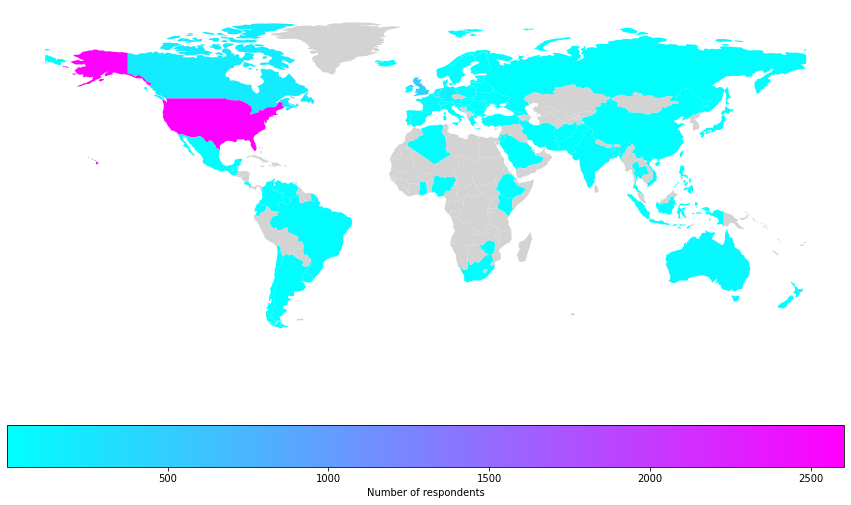

In [48]:
world_filepath = geopandas.datasets.get_path('naturalearth_lowres')

world = geopandas.read_file(world_filepath)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

world_map_repondents = world.set_index('name') \
                       .join(respondent_country \
                       .set_index('country_name'))

axis = world_map_repondents.plot(column='no_respondents',
                                figsize=(15,10), 
                                cmap='cool',
                                missing_kwds={'color': 'lightgrey'},
                                legend=True, 
                                legend_kwds={'label': "Number of respondents",
                                            'orientation': "horizontal"})

axis.axis('off');

We see that the respondents spread across different countries and continents. The following graph represents 10 countries with most the respondents.

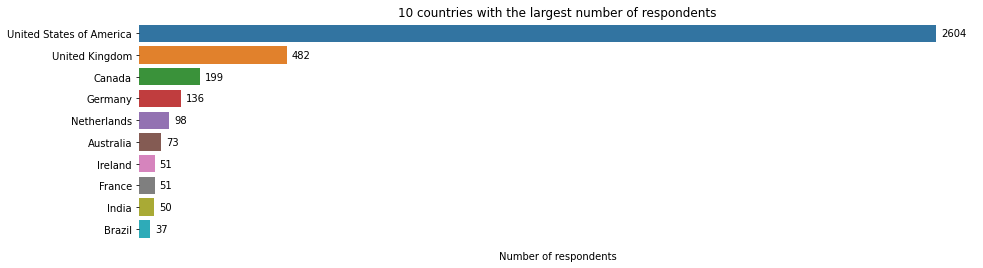

In [49]:
plt.figure(figsize=(15, 4))

axis = sns.barplot(y=respondent_country["country_name"][:10],
                   x=respondent_country["no_respondents"][:10],
                   orient='h',)

sns.despine(bottom=True, left=True)

annotate_bars(axis)

axis.set_title('10 countries with the largest number of respondents')
axis.set_xlabel('Number of respondents')
axis.set_ylabel(None)
axis.set(xticklabels=[]) 
axis.grid(False)

axis.tick_params(axis='x', bottom=False)

Most of the people who filled in the survey come from North America, Europe, Australia, India and Brazil.

## Mental health of survey respondents



In this section, we will investigate the overall prevalence of mental disorders among repondents and aim to determine the magnitude of the disorders' interference with their work.

### How many repondents work in technology sector?

The database description states that the survey measures the attitudes towards mental health and frequency of mental health disorders in the tech workplace. We will first check whether the respondents indeed work in tech sector by investigating the answers to 2 questions.

#### Is your employer primarily a tech company/organization?


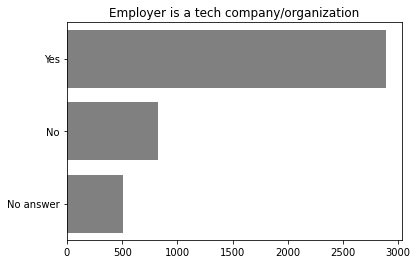

In [50]:
tech_company = pd.read_sql("""
                            SELECT AnswerText AS answer, 
                                   COUNT(DISTINCT UserID) AS no_respondents
                            FROM (SELECT AnswerText, UserID
                                 FROM Answer
                                 WHERE QuestionID = 9) 
                            GROUP BY AnswerText
                            ORDER BY no_respondents DESC
                            """, connection)

axis = sns.barplot(x="no_respondents",
            y="answer",
            data=tech_company, color="grey");

axis.set(yticklabels=["Yes", "No", "No answer"])
plt.title("Employer is a tech company/organization")
plt.xlabel(None)
plt.ylabel(None);

#### Is your primary role within your company related to tech/IT?

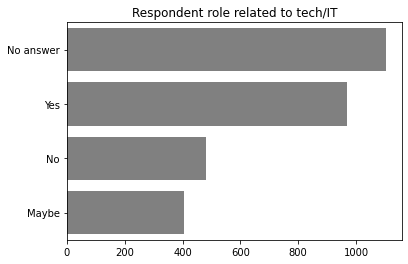

In [51]:
it_role = pd.read_sql("""
                      SELECT AnswerText AS answer, 
                              COUNT(DISTINCT UserID) AS no_respondents
                      FROM (SELECT AnswerText, UserID
                            FROM Answer
                            WHERE QuestionID = 31) 
                      GROUP BY AnswerText
                      ORDER BY no_respondents DESC
                      """, connection)

axis = sns.barplot(x="no_respondents",
            y="answer",
            data=it_role, color="grey");

axis.set(yticklabels=["No answer", "Yes", "No", "Maybe"])
plt.title("Respondent role related to tech/IT")
plt.xlabel(None)
plt.ylabel(None);

We see that the assumption about survey respondents working in tech sectors is not met fully - some of the respondents seem to not be working in tech companies. Only 482 individuals claimed that their primary role is related to tech/IT. Hence, we will be careful about generalizing the conclusions to the technology sector workers and rather focus on the insights of the survey respondents (regardless of their working field). 

### How many respondents have mental disorders?

We will use the following 3 questions concerning mental health status to determine the number of health tech professionals that currently has or has had a mental disorder in the past.

In [52]:
mental_health_questions = pd.read_sql("""
                                      SELECT * 
                                      FROM Question
                                      WHERE QuestionID IN (32, 33, 34)
                                      """, connection)

mental_health_questions.set_index('questionid')

,questiontext
questionid,
32,Have you had a mental health disorder in the p...
33,Do you currently have a mental health disorder?
34,Have you ever been diagnosed with a mental hea...


Next, we will represent the proportion of answers to these questions.

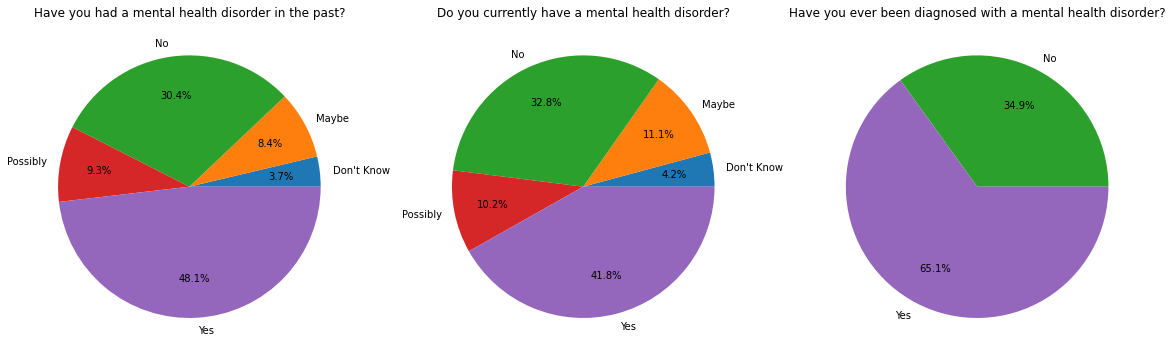

In [53]:
#@title Derive and plot answer about mental disorder status
past_mental_disorders = pd.read_sql("""
                                    SELECT AnswerText AS answer, 
                                           COUNT(DISTINCT UserID) AS count_past
                                    FROM (SELECT AnswerText, UserID
                                          FROM Answer
                                          WHERE QuestionID = 32 
                                          AND AnswerText IS NOT '-1') 
                                    GROUP BY answer
                                    """, connection)

current_mental_disorders = pd.read_sql("""
                                      SELECT AnswerText AS answer, 
                                             COUNT(DISTINCT UserID) 
                                             AS count_current
                                      FROM (SELECT AnswerText, UserID
                                            FROM Answer
                                            WHERE QuestionID = 33 
                                            AND AnswerText IS NOT '-1') 
                                      GROUP BY answer
                                      """, connection)

diagnosed_mental_disorders = pd.read_sql("""
                                        SELECT AnswerText AS answer, 
                                               COUNT(DISTINCT UserID) 
                                               AS count_diagnosed
                                        FROM(SELECT AnswerText, UserID
                                             FROM Answer
                                             WHERE QuestionID = 34 
                                             AND AnswerText IS NOT '-1') 
                                        GROUP BY answer
                                        """, connection)

disorder_status = past_mental_disorders \
                  .merge(current_mental_disorders, on='answer', how='left') \
                  .merge(diagnosed_mental_disorders, on='answer', how='left') \
                  .set_index('answer') \
                  .fillna(0) \
                  .astype('int')

axes = disorder_status.plot(kind='pie',
                            figsize=(20, 18),
                            subplots=True,
                            pctdistance=0.7,
                            autopct=show_nonzero, legend=False);

for axis in axes:
  axis.get_yaxis().set_visible(False);

axes[0].set_title("Have you had a mental health disorder in the past?");
axes[1].set_title("Do you currently have a mental health disorder?");
axes[2].set_title("Have you ever been diagnosed with a mental health disorder?");

We see that proportion of people who have reported having mental problems is more than 41.8%. Even more (65%) reported having been diagnosed having a mental disorder in the past. These numbers are higher in comparison to the general population. Globally, [11-18%](https://ourworldindata.org/global-mental-health) of people have one or more mental disorders.

### Mental well-being factors

Mental well-being can be influenced by many factors. We will investigate some of them aiming to get some insights about what makes the tech professionals more or less prone to getting a mental disorder.

#### Age

We are interested in how the number of people who have/had mental disorder are distributed across different age groups. For this analysis, the answers to the previous questions will be grouped into 2 categories: *yes*, *no/uncertain*. The first group will encompass only *yes* answers and the second will merge other answers, such as *no, maybe, possibly.*

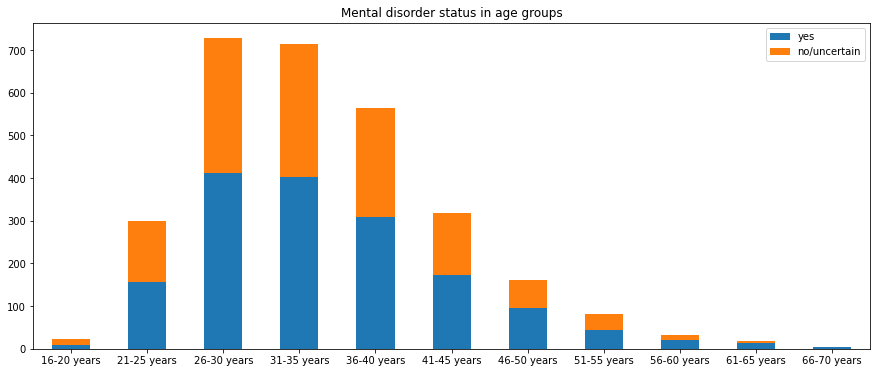

In [54]:
#@title Derive and plot mental disorder status in different age groups 
mental_disorder_age = pd.read_sql("""
                                  WITH respondent_age AS
                                      (SELECT UserID as ID, 
                                              CAST(AnswerText AS int) As age
                                      FROM Answer
                                      WHERE QuestionID = 1 
                                      AND Age >= 18 
                                      AND Age <= 70)

                                  SELECT *,
                                      SUM (CASE WHEN AnswerText = 'Yes' THEN 1
                                          ELSE 0 
                                          END) AS yes_answer_counts, 
                                     (CASE
                                          WHEN age > 15 
                                          AND age <= 20 THEN '16-20 years'
                                          WHEN age > 20 
                                          AND age <= 25 THEN '21-25 years'
                                          WHEN age > 25 
                                          AND age <= 30 THEN '26-30 years'
                                          WHEN age > 30 
                                          AND age <= 35 THEN '31-35 years'
                                          WHEN age > 25 
                                          AND age <= 40 THEN '36-40 years'
                                          WHEN age > 40 
                                          AND age <= 45 THEN '41-45 years'
                                          WHEN age > 45 
                                          AND age <= 50 THEN '46-50 years'
                                          WHEN age > 50 
                                          AND age <= 55 THEN '51-55 years'
                                          WHEN age > 55 
                                          AND age <= 60 THEN '56-60 years'
                                          WHEN age > 60 
                                          AND age <= 65 THEN '61-65 years'
                                          WHEN age > 65 
                                          AND age <= 70 THEN '66-70 years'
                                      END) AS age_group
                                  FROM Answer
                                  JOIN respondent_age
                                  ON Answer.UserID = respondent_age.ID
                                  WHERE QuestionID IN (32, 33, 34) 
                                  AND AnswerText IS NOT '-1'
                                  GROUP BY respondent_age.ID
                                  """, connection)

yes_mask = mental_disorder_age['yes_answer_counts'] > 0
mental_disorder_age.loc[yes_mask, 'yes'] = 1
mental_disorder_age.loc[~yes_mask, 'no/uncertain'] = 1
mental_disorder_age[['age_group', 'yes', 'no/uncertain']] \
                     .fillna(0) \
                     .groupby('age_group') \
                     .sum() \
                     .plot(kind='bar', 
                           stacked=True, 
                           rot=0, 
                           figsize=(15,6));

plt.title("Mental disorder status in age groups")
plt.xlabel(None);

The proportion of people who have or had the disorder at some point of their life tends to get higher with age.  

#### Company size

Company size might also be an important factor for mental well-being. For example, due to the high number of people, larger companies might fail to notice and support employees struggling with mental health. On the other hand, smaller companies may not have the well-established infrastructure to help the employees with mental issues.

We will look at the mental disorder status in companies of different sizes.

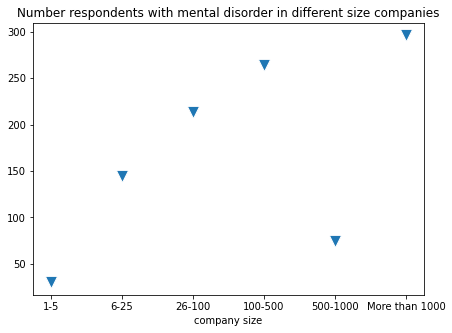

In [55]:
company_size = pd.read_sql("""
                          WITH company_size AS 
                              (SELECT AnswerText AS answer, UserID AS ID
                              FROM Answer
                              WHERE QuestionID = 8 
                              AND AnswerText IS NOT "-1")

                          SELECT answer, 
                                 COUNT(DISTINCT UserID) AS have_mental_disorder
                          FROM Answer
                          JOIN company_size
                          ON Answer.UserID = company_size.ID
                          WHERE QuestionID = 33 
                          AND AnswerText IS "Yes" 
                          AND AnswerText IS NOT "-1"
                          GROUP BY answer
                          ORDER BY answer
                          """, connection)

size_range = ["1-5", "6-25", "26-100", "100-500" , "500-1000", "More than 1000"]
company_size["answer"]= pd.Categorical(company_size["answer"], size_range)

plt.figure(figsize=(7, 5))
sns.scatterplot(x="answer", 
                y="have_mental_disorder", 
                data=company_size, 
                marker="v", 
                s=150)

plt.title("Number respondents with mental disorder in different size companies")
plt.xlabel("company size");
plt.ylabel(None);

With an exception of companies having 500-1000 employees, the number of people who reported currently having a mental health disorder seems to increase together with increasing company size.

## Mental disorder interference with work

Using the following questions we will investigate whether and to which extent mental disorder interferes with the tech professionals' work.

In [56]:
interference_questions = pd.read_sql("""
                                    SELECT * 
                                    FROM Question
                                    WHERE QuestionID IN (48, 49, 54, 55)
                                    """, connection)

interference_questions.set_index('questionid')

,questiontext
questionid,
48,"If you have a mental health disorder, how ofte..."
49,"If you have a mental health disorder, how ofte..."
54,Do you believe your productivity is ever affec...
55,"If yes, what percentage of your work time (tim..."


The following graphs summarize the answers of those who found the question about mental disorder interference applicable to them. 

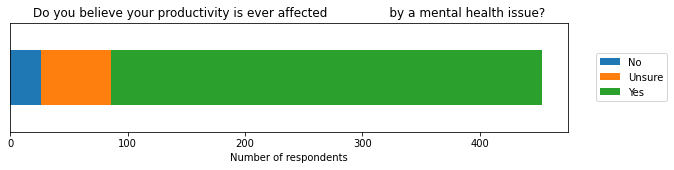

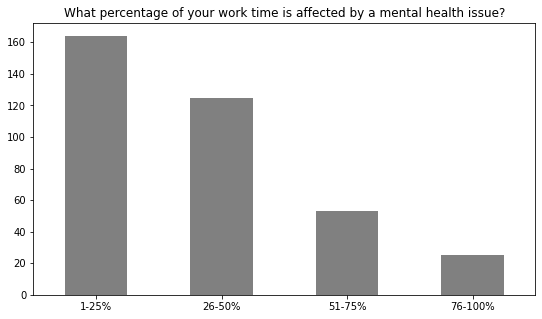

In [57]:
#@title Derive and plot answer about mental disorder and work interference
productivity = pd.read_sql("""
                          SELECT AnswerText AS answer, 
                                 COUNT(DISTINCT UserID) AS no_respondents
                          FROM (SELECT AnswerText, UserID, QuestionID
                                FROM Answer
                                WHERE QuestionID=54 
                                AND AnswerText IS NOT "-1" 
                                AND AnswerText IS NOT "Not applicable to me") 
                          GROUP BY answer, QuestionID
                          """, connection)

productivity_percentage = pd.read_sql("""
                                      SELECT AnswerText AS answer,
                                             COUNT(DISTINCT UserID) 
                                             AS no_respondents
                                      FROM (SELECT AnswerText, UserID, QuestionID
                                            FROM Answer
                                            WHERE QuestionID=55 
                                            AND AnswerText IS NOT "-1" 
                                            AND AnswerText IS NOT 
                                            "Not applicable to me") 
                                      GROUP BY answer, QuestionID
                                      """, connection)

productivity.set_index('answer', inplace=True)

axis0 = productivity.T.plot.barh(stacked=True, figsize=(10,2))
axis0.set_title("Do you believe your productivity is ever affected\
                by a mental health issue?")

axis0.set_xlabel("Number of respondents");
axis0.set(yticklabels=[])
axis0.tick_params(axis='y', left=False)
axis0.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

axis1 = productivity_percentage \
       .set_index("answer") \
       .plot(kind="bar", 
             stacked=True, 
             rot=0, 
             figsize=(9, 5), 
             legend=False, 
             color="grey");
             
axis1.set_title("What percentage of your work time is affected by a mental\
 health issue?");
 
axis1.set_xlabel(None);

The majority of respondents believe that their productivity is affected by the mental disorder. Most of them report that it affects less than 25% of their work time.

Furthermore, the mental disorder's effects could vary based on how well it is treated or managed. We will look at questions 48 and 49 to investigate this further.

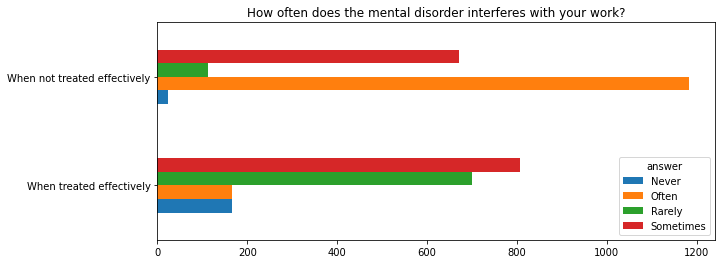

In [58]:
interference_treatment = pd.read_sql("""
                                    SELECT AnswerText AS answer, 
                                           COUNT(DISTINCT UserID)
                                           AS no_respondents, QuestionID
                                    FROM (SELECT AnswerText, UserID, QuestionID
                                          FROM Answer
                                          WHERE QuestionID IN (48, 49) 
                                          AND AnswerText IS NOT "-1" 
                                          AND AnswerText NOT LIKE "%applicable%")
                                    GROUP BY answer, QuestionID
                                    """, connection)

interference = pd.pivot_table(interference_treatment,
                              values="no_respondents",
                              index="QuestionID",
                              columns="answer")

axis = interference.plot.barh(rot=0, figsize=(10, 4));

plt.title("How often does the mental disorder interferes with your work?") 
axis.set_yticklabels(["When treated effectively",
                      "When not treated effectively"]);
axis.set(ylabel=None);

We see that when treated effectively, for most of the respondents the disorder tends to interfere with their work only sometimes. When not treated properly, respondents find their work to be affected more often.   

Collectively, these answers emphasise the importance of acknowledging the mental disorder and taking actions for managing it to support productivity at work. In the next section, we will analyze whether and how this support is facilitated by the employers.

## Employer support and attitude



Some of the questions in the questionnaire measure the support for mental health provided by the employer.

In [59]:
interference_questions = pd.read_sql("""
                                    SELECT * 
                                    FROM Question
                                    WHERE QuestionID IN (10, 16, 17, 50, 64, 65)
                                    """, connection)

interference_questions.set_index("questionid")

,questiontext
questionid,
10,Does your employer provide mental health benef...
16,Does your employer offer resources to learn mo...
17,If a mental health issue prompted you to reque...
50,What country do you work in?
64,"Overall, how much importance does your employe..."
65,"Overall, how much importance does your employe..."


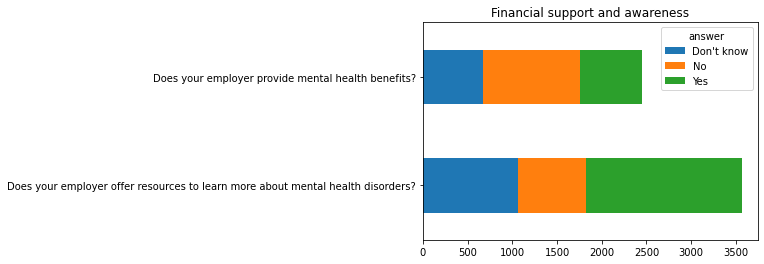

In [60]:
employer_support = pd.read_sql("""
                              SELECT answer, 
                                     COUNT(DISTINCT UserID) AS no_respondents, 
                                     QuestionID
                              FROM (SELECT
                                          CASE
                                              WHEN AnswerText LIKE "%know%" 
                                              THEN "Don't know"
                                              ELSE AnswerText
                                          END AS answer, 
                                          UserID, QuestionID
                                    FROM Answer
                                    WHERE QuestionID IN (10, 16) 
                                    AND AnswerText IS NOT "-1" 
                                    AND AnswerText NOT LIKE "%NA")
                              GROUP BY answer, QuestionID
                              """, connection)


employer_support = pd.pivot_table(employer_support, 
                                  values="no_respondents", 
                                  index="QuestionID",
                                  columns="answer")

axis = employer_support.plot.barh(rot=0, stacked=True);

plt.title("Financial support and awareness") 
axis.set_yticklabels(["Does your employer offer resources to learn more about \
mental health disorders?",
                      "Does your employer provide mental health benefits?"]);
axis.set(ylabel=None);

Based on survey responses provided above, most of the employers do not provide mental health benefits. However, most of them facilitate the resources for learning more about mental health disorders.

There might also be some cultural differences towards mental health and stigmas surrounding this topic. To check this hypothesis, the answers to the following questions about employer's support will be grouped by continent. 

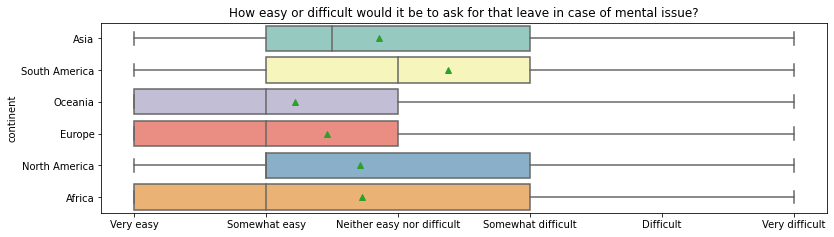

In [61]:
#@title Difficulty to leave work analysis
leave_work_country = pd.read_sql("""
                                  WITH work_country AS
                                      (SELECT UserID as ID, 
                                      AnswerText as country
                                      FROM Answer
                                      WHERE QuestionID = 50)

                                  SELECT country, 
                                        (CASE 
                                            WHEN AnswerText IS "Very easy" THEN 0
                                            WHEN AnswerText 
                                            IS "Somewhat easy" THEN 1
                                            WHEN AnswerText 
                                            IS "Neither easy nor difficult" THEN 2
                                            WHEN AnswerText 
                                            IS "Somewhat difficult"	THEN 3
                                            WHEN AnswerText IS "Difficult"	THEN 4
                                            WHEN AnswerText 
                                            IS "Very difficult" THEN 5
                                        END) AS rating
                                  FROM Answer
                                  JOIN work_country
                                  ON Answer.UserID = work_country.ID
                                  WHERE QuestionID = 17 
                                  AND AnswerText IS NOT "I don''t know" 
                                  AND AnswerText IS NOT "-1"
                                  """, connection)

leave_work_continent = leave_work_country \
                       .set_index('country') \
                       .join(world.loc[:, ['continent', 'name']]
                       .set_index('name'))

plt.figure(figsize=(13, 3.5))
axis = sns.boxplot(x="rating", 
                   y="continent", 
                   data=leave_work_continent, 
                   showmeans=True, 
                   palette="Set3");

plt.title("How easy or difficult would it be to ask for that leave in case\
 of mental issue?")
axis.set_xticklabels(["", 
                      "Very easy", 
                      "Somewhat easy", 
                      "Neither easy nor difficult", 
                      "Somewhat difficult", 
                      "Difficult", 
                      "Very difficult"]);

axis.set_xlabel(None);

We see that there are some variations in terms of difficulty of leaving in case of mental illness across continents. Most of the participants working in Europe, Oceania, Africa and North America indicated that it would be *Somewhat easy* for them to leave due to mental illness. People from North America tend to lean towards the difficult side a bit more as 50% of the respondents reside between *Somewhat easy* and *Somewhat difficult*. This tendency is similar in South America and Asia. It seems that the respondents from South America would find it most difficult to leave due to mental issues since the median and mean values are highest for this continent.

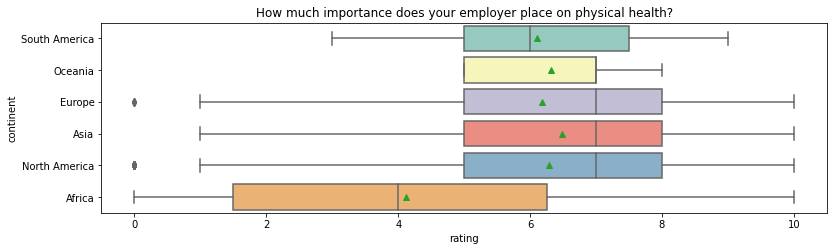

In [62]:
#@title Physical health importance analysis
physical_health_country = pd.read_sql("""
                                      WITH work_country AS 
                                          (SELECT UserID as ID, 
                                                  AnswerText AS country
                                          FROM Answer
                                          WHERE QuestionID = 50)

                                      SELECT country, 
                                             CAST(AnswerText AS int) AS rating
                                      FROM Answer
                                      JOIN work_country
                                      ON Answer.UserID = work_country.ID
                                      WHERE QuestionID = 64 
                                      AND AnswerText IS NOT "I don''t know" 
                                      AND AnswerText IS NOT "-1"
                                      """, connection)

physical_health_continent = physical_health_country \
                           .set_index('country') \
                           .join(world.loc[:, ['continent', 'name']] \
                            .set_index('name'))

plt.figure(figsize=(13, 3.5))
sns.boxplot(x="rating", 
            y="continent", 
            data=physical_health_continent, 
            showmeans=True, 
            palette="Set3")

plt.title("How much importance does your employer place on physical health?");

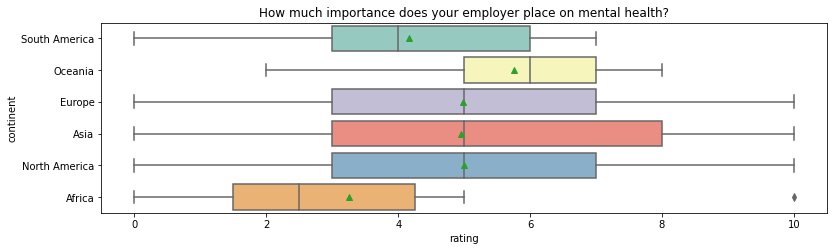

In [63]:
#@title Mental health importance analysis
mental_health_country = pd.read_sql("""
                                    WITH work_country AS 
                                        (SELECT UserID as ID, AnswerText 
                                                AS country
                                        FROM Answer
                                        WHERE QuestionID = 50)

                                    SELECT country, 
                                           CAST(AnswerText AS int) AS rating
                                    FROM Answer
                                    JOIN work_country
                                    ON Answer.UserID = work_country.ID
                                    WHERE QuestionID = 65 
                                    AND AnswerText IS NOT "I don''t know" 
                                    AND AnswerText IS NOT "-1"
                                    """, connection)

mental_health_continent = mental_health_country \
                          .set_index('country') \
                          .join(world.loc[:, ['continent', 'name']] \
                          .set_index('name'))

plt.figure(figsize=(13, 3.5))
sns.boxplot(x="rating", 
            y="continent", 
            data=mental_health_continent, 
            showmeans=True, palette="Set3")

plt.title("How much importance does your employer place on mental health?");

Looking at the graphs above, we see that the employer place less importance on the mental in comparison to physical health. Usually, it is lower by 2 scores. Exceptions are Oceania and Africa where the difference is less than 2 scores. The highest mental health importance median and mean scores were obtained for Oceania and the lowest for Africa.

In summary, while employers make the effort to raise awareness about mental health, the financial benefits seem to be provided less often. Furthermore, in different parts of the world, physical health is emphasized more than mental health.

## Employee attitude

In addition to employers view on mental health, employees attitude is important for recognizing and managing mental problems. 

Using the following question we will take a deeper look into this matter.

In [64]:
mental_health_questions = pd.read_sql("""
                    SELECT * 
                    FROM Question
                    WHERE QuestionID IN (12, 18, 19, 98)
                    """, connection)

mental_health_questions.set_index('questionid')

,questiontext
questionid,
12,Would you bring up a mental health issue with ...
18,Would you feel comfortable discussing a mental...
19,Would you feel comfortable discussing a mental...
98,Do you think that discussing a mental health i...


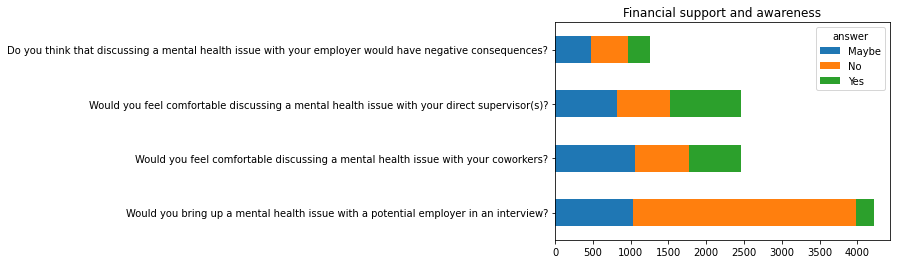

In [65]:
#@title Employee attitude analysis
employee_attitude = pd.read_sql("""
                                SELECT AnswerText AS answer, 
                                       COUNT(DISTINCT UserID) AS count_past, 
                                       QuestionID
                                FROM (SELECT AnswerText, UserID, QuestionID
                                      FROM Answer
                                      WHERE QuestionID IN (12, 18, 19, 98) 
                                      AND AnswerText IS NOT "-1") 
                                GROUP BY answer, QuestionID
                                """, connection)

employee_attitude = pd.pivot_table(employee_attitude,
                                   values='count_past', 
                                   index=['QuestionID'], 
                                   columns=['answer'])

axis = employee_attitude.plot.barh(rot=0, stacked=True);

plt.title("Financial support and awareness") 
axis.set_yticklabels(["Would you bring up a mental health issue with a potential\
 employer in an interview?",
                      "Would you feel comfortable discussing a mental health\
 issue with your coworkers?",
                      "Would you feel comfortable discussing a mental health\
 issue with your direct supervisor(s)?", 
                      "Do you think that discussing a mental health issue with\
 your employer would have negative consequences?" ]);

axis.set(ylabel=None);

Although a relatively small portion of respondents believes that bringing up the mental health issue to their employer would have negative consequences, not many of them would be willing to reveal it during a potential employer interview. Approximately one-third of respondents would feel comfortable with sharing discussing their mental health with their supervisors, but less would be willing to discuss it with their coworkers. The bigger proportion answered *maybe* or *no* to these questions.

Mental health started receiving [more attention in recent years](https://www.nbcnews.com/better/lifestyle/mental-health-how-we-ve-improved-where-we-need-do-ncna1108721). Hence, we will look whether this change can be observed in the survey data. The proportion of people who sought help when having mental concerns will be plotted across different years.

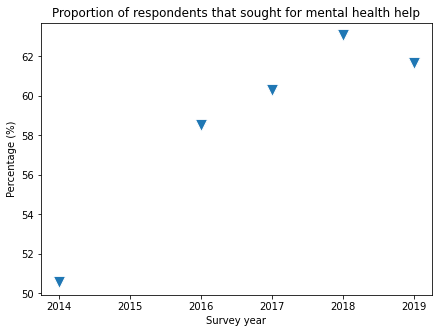

In [66]:
#@title Seeking help tendencies analysis
years_seeking_help = pd.read_sql("""
                                SELECT AnswerText, SurveyID, 
                                       COUNT(DISTINCT UserID) AS no_respondents
                                FROM Answer
                                WHERE QuestionID = 7
                                GROUP BY SurveyID, AnswerText
                                """, connection)

total_count = years_seeking_help.groupby('SurveyID').sum()
total_yes= years_seeking_help \
           .loc[years_seeking_help['AnswerText'] == '1', 
            ['SurveyID', 'no_respondents']]

seeking_help = total_count \
               .join(total_yes \
               .set_index('SurveyID'), 
               how='left', 
               lsuffix='_total', 
               rsuffix='_seek_help')

seeking_help['percentage'] = seeking_help['no_respondents_seek_help'] \
                             /seeking_help['no_respondents_total']*100

plt.figure(figsize=(7, 5))
sns.scatterplot(x=seeking_help.index, 
                y="percentage", 
                data=seeking_help, 
                marker="v", 
                s=150)

plt.title("Proportion of respondents that sought for mental health help")
plt.xlabel("Survey year");
plt.ylabel("Percentage (%)");

We see that with some variations, the percentage of people seeking help increased by almost 10% from the year 2014 and 2019. Besides that, the participants of the survey do not seem to be keen to talk about their mental disorders in a work environment.

## Conclusions

* In comparison to the general population, the proportion of the survey respondents experiencing mental health issues is higher.
* When treated effectively, the disorder seems to interfere with work less. Therefore, actions should be taken to help employees to manage mental disorders and support their mental well-being.
* Employees seem to recognise the employers' effort in educating them about potential help resources. However, most respondents perceived physical health as more emphasised by the employer than mental health. It should be further investigated why this is the case and how it can be improved.
* Even though more people seem to be seeking help when experiencing mental problems in recent years, most of them do not feel comfortable talking about mental issues with their current or future employers.


Overall, there seems to be a lot of room for improvement to prevent workers from getting mental disorder as well as managing it in case of occurrence.